#  Using t-SNE as a technique to recommend movies based on similarities

The aim of this study is to recommend movies based on movie posters. 

We start by analyzing a large set of movie posters using a pre-trained convolutional network, extracting feature vectors for each one of the movie posters. 

After extracting the feature vectors PCA will be applied to reduce the dimensionalities of the features. Then t-sne will be applied which reduces the dimensionalities further down, and the output of the t-sne will be visualised. Lastly the recommendations to a random movie will be given based on the movie poster. 

### The dataset of movie posters

The dataset with movie posters that will be used is retrieved from (https://www.cs.ccu.edu.tw/~wtchu/projects/MoviePoster/index.html). The dataset consisting of 8087 movie posters devided between 36 folders, labelled the years from 1980 to 2005.

In [1]:
import os
import cv2
import keras
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot
from matplotlib.pyplot import imshow
from tensorflow.keras.layers.experimental.preprocessing import RandomRotation
from tensorflow.python.tools import module_util as _module_util
from tensorflow.python.util.lazy_loader import LazyLoader as _LazyLoader
from tensorflow.python.eager import context
from keras.preprocessing import image
from keras.applications.imagenet_utils import decode_predictions, preprocess_input
from keras.models import Model    
import tarfile
import time
%matplotlib inline
import random
import json
from PIL import Image
from sklearn.manifold import TSNE
from PIL import Image

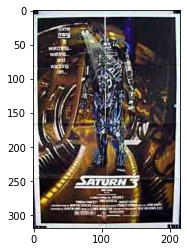

In [2]:
DATADIR = "C:/Users/Sabah Afzal/Movie_Poster_Dataset"
CATEGORIES = ["1980", "1981", "1982", "1983", "1984", "1985", "1986", "1987", "1988", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015"]

for category in CATEGORIES:
    path = os.path.join(DATADIR, category) #path to the different categories
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))
        plt.imshow(img_array)
        plt.show()
        break
    break

We will load a previously-trained neural network, that of VGG16, which comes with Keras.

In [3]:
model = keras.applications.VGG16(weights='imagenet', include_top=True)

In [4]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

The output shape at each layer has 'None'as the first dimension. This is because the network can process multiple images in a single batch.

### Forwarding an image through the network

In order to input an image into the network, it has to be pre-processed into a feature vector of the correct size. To help us do this, we will create a function `load_image(path)` which will handle the usual pre-processing steps: load an image from our file system and turn it into an input vector of the correct dimensions, those expected by VGG16, namely a color image of size 224x224.

In [5]:
def load_image(path):
    img = image.load_img(path, target_size=model.input_shape[1:3])
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return img, x

We'll load the image of movie poster and take a look at its data vector.

shape of x:  (1, 224, 224, 3)
data type:  float32


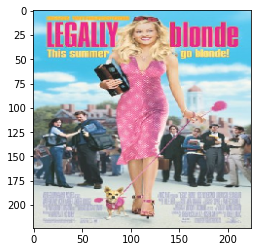

In [6]:
img, x = load_image("Movie_Poster_Dataset/2001/tt0250494.jpg")
print("shape of x: ", x.shape)
print("data type: ", x.dtype)
plt.imshow(img)

The shape of the image is [1, 224, 224, 3]. The reason it has the extra first dimension with 1 element is that the network can take batches of images to process them all simultaneously. So for example, 10 images can be propagated through the network if `x` has a shape of [10, 224, 224, 3].

Let's get class predictions from this model. We forward `x` through `model` and then use the built-in `decode_predictions` to look up the class names.

In [7]:
# forward the image through the network
predictions = model.predict(x)

# print out the 
for _, pred, prob in decode_predictions(predictions)[0]:
    print("predicted %s with probability %0.3f" % (pred, prob))

predicted maillot with probability 0.318
predicted maillot with probability 0.235
predicted web_site with probability 0.129
predicted bikini with probability 0.037
predicted stage with probability 0.032


### Feature extraction

To use the model for feature extraction we remove the last layer (the classification layer), so that the final layer of the new network, called 'feat_extractor' is the second 4096-neuron fully-connected layer, 'fc2 (Dense)'.

The way we do this is by instantiating a new model called 'feature_extractor' which takes a reference to the desired input and output layers in our VGG16 model. Thus, 'feature_extractor's output is the layer just before the classification, the last 4096-neuron fully connected layer.

If we run the 'summary'function again, we see that the architecture of 'feat_extractor' is identical to the original 'model', except the last layer has been removed. We also know that not just the architecture is the same, but the two have the same weights as well.

In [8]:
feat_extractor = Model(inputs=model.input, outputs=model.get_layer("fc2").output)
feat_extractor.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

Now let's see the feature extractor in action. We pass the same image from before into it, and look at the results. The `predict` function returns an array with one element per image. Each element contains a 4096-element array, which is the activations of the last fully-connected layer 'fc2' in VGG16.

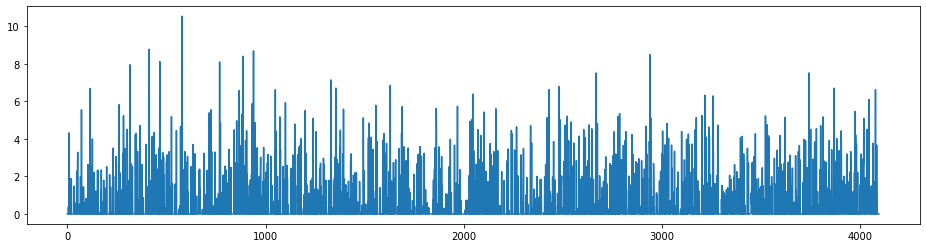

In [9]:
img, x = load_image("Movie_Poster_Dataset/1998/tt0118301.jpg")
feat = feat_extractor.predict(x)

plt.figure(figsize=(16,4))
plt.plot(feat[0])

Our expectation is that the 'fc2' activations form a very good representation of the image, such that similar images should produce similar activations. We can exploit this to do information retrieval. 

In the next cell, we will open a folder of images for analysis. First, the next cell will just recursively crawl the folder specified by 'image_path' looking for images of the extensions inside of 'image_extensions' and then limiting them to a random subset of maximum 'max_num_images' images. Change these variables if you wish to change the target images.

In [12]:
images_path = 'Movie_Poster_Dataset'
image_extensions = ['.jpg', '.png', '.jpeg']   # case-insensitive (upper/lower doesn't matter)
max_num_images = 1000

images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(images_path) for f in filenames if os.path.splitext(f)[1].lower() in image_extensions]
if max_num_images < len(images):
    images = [images[i] for i in sorted(random.sample(range(len(images)), max_num_images))]

print("keeping %d images to analyze" % len(images))

keeping 1000 images to analyze


In the next cell, we will begin a loop which will open each image, extract its feature vector, and append it to a list called 'features' which will contain our activations for each image.

In [13]:
tic = time.process_time()


features = []
for i, image_path in enumerate(images):
    if i % 500 == 0:
        toc = time.process_time()
        elap = toc-tic;
        print("analyzing image %d / %d. Time: %4.4f seconds." % (i, len(images),elap))
        tic = time.process_time()
    img, x = load_image(image_path);
    feat = feat_extractor.predict(x)[0]
    features.append(feat)

print('finished extracting features for %d images' % len(images))

analyzing image 0 / 1000. Time: 0.0000 seconds.
analyzing image 500 / 1000. Time: 983.2812 seconds.
finished extracting features for 1000 images


These activations provide a good representation, but we will perform a Principal Component Analysis (PCA) to reduce the dimensionality of our feature vectors down to 300. PCA allows us to do this by reducing the dimensionality down of the feature vectors but maintain a representation which is still faithful to the original data, by preserving the relative inter-point distance.

The next cell will instantiate a 'PCA' object, which we will then fit our data to, choosing to keep the top 300 principal components.

In [14]:
from sklearn.decomposition import PCA

features = np.array(features)
pca = PCA(n_components=300)
pca.fit(features)

PCA(n_components=300)

The 'pca' object stores the actual transformation matrix which was fit in the previous cell. We can now use it to transform any original feature vector (of length 4096) into a reduced 300-dimensional feature vector in the principal component space found by the PCA. 

So we take our original feature vectors, and transform them to the new space.

In [15]:
pca_features = pca.transform(features)

We are now ready to do our reverse image queries! The matrix `pca_features` contains a compact representation of our images, one 300-element row for each image with high-level feature detections. We should expect that two similar images, which have similar content in them, should have similar arrays in `pca_features`.

Let's pick a random query image.

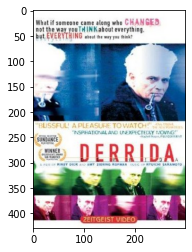

In [16]:
# grab a random query image
query_image_idx = int(len(images) * random.random())

# let's display the image
img = image.load_img(images[query_image_idx])
plt.imshow(img)

The assumption we can now make is that two images which have similar content, should produce similar feature vectors. The next two cells will randomly select one image, and then compute a measurement of the dissimilarity (or distance) of that image's PCA feature vector to every other image's feature vector. The dissimilarity metric we use is 'Cosine Distance'.

In [17]:
from scipy.spatial import distance

similar_idx = [ distance.cosine(pca_features[query_image_idx], feat) for feat in pca_features ]

The list `similar_idx` contains the image's similarity to every other one. We can sort that list and find the indexes of the most similar images. The next cell will sort them, and then find the most similar items, and return the indexes 5 most similar images. Notice we take from indexes 1:6 rather than 0:5 because the most similar image to the query image, will trivially be the query image itself, since it is included in the distance calculation. So we just skip it.

In [18]:
idx_closest = sorted(range(len(similar_idx)), key=lambda k: similar_idx[k])[1:6]

The next cell opens the images specified by `idx_closest` and concatenates them into a single image (resizing each so it has a height of 100 pixels.

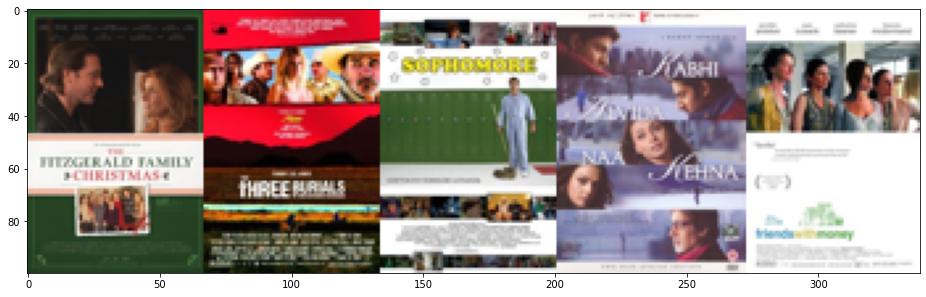

In [19]:
# load all the similarity results as thumbnails of height 100
thumbs = []
for idx in idx_closest:
    img = image.load_img(images[idx])
    img = img.resize((int(img.width * 100 / img.height), 100))
    thumbs.append(img)

# concatenate the images into a single image
concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)

# show the image
plt.figure(figsize = (16,12))
plt.imshow(concat_image)

## Applying t-SNE
We will now apply t-SNE to the data and setting the components to 2 and the perplexity to 30.

In [20]:
num_images_to_plot = 1000

if len(images) > num_images_to_plot:
    sort_order = sorted(random.sample(range(len(images)), num_images_to_plot))
    images = [images[i] for i in sort_order]
    pca_features = [pca_features[i] for i in sort_order]


In [21]:
X = np.array(pca_features)
tsne = TSNE(n_components=2, learning_rate=15, perplexity=30, angle=0.2, verbose=2).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.079s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 17.479157
[t-SNE] Computed conditional probabilities in 0.144s
[t-SNE] Iteration 50: error = 66.9880447, gradient norm = 0.0000002 (50 iterations in 0.696s)
[t-SNE] Iteration 100: error = 66.9648895, gradient norm = 0.0000000 (50 iterations in 0.638s)
[t-SNE] Iteration 100: gradient norm 0.000000. Finished.
[t-SNE] KL divergence after 100 iterations with early exaggeration: 66.964890
[t-SNE] Iteration 150: error = 3.0974441, gradient norm = 0.0000073 (50 iterations in 0.564s)
[t-SNE] Iteration 200: error = 2.2571168, gradient norm = 0.0022946 (50 iterations in 0.540s)
[t-SNE] Iteration 250: error = 2.1797550, gradient norm = 0.0010923 (50 iterations in 0.556s)
[t-SNE] Iteration 300: error = 2.1389213, gradient norm = 0.0006512 (50 iterations in 0.521s)
[t-SNE] It

In [22]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

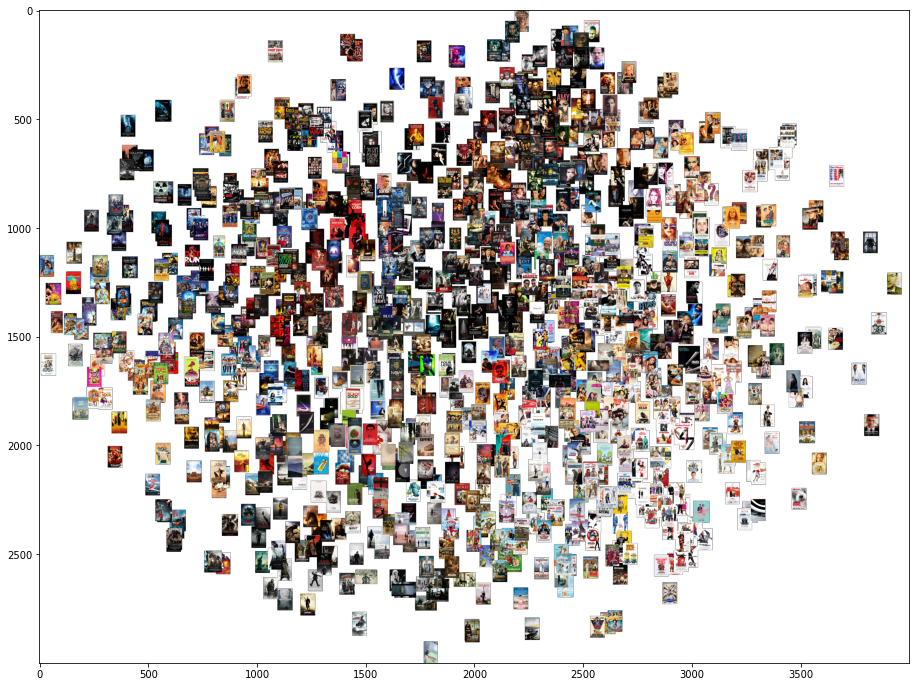

In [23]:
width = 4000
height = 3000
max_dim = 100

full_image = Image.new('RGBA', (width, height))
for img, x, y in zip(images, tx, ty):
    tile = Image.open(img)
    rs = max(1, tile.width/max_dim, tile.height/max_dim)
    tile = tile.resize((int(tile.width/rs), int(tile.height/rs)), Image.ANTIALIAS)
    full_image.paste(tile, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=tile.convert('RGBA'))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(full_image)

In [24]:
full_image.save("C:/Users/Sabah Afzal/example-tSNE-MoviePosters14.png")

In [25]:
tsne_path = "C:/Users/Sabah Afzal/example-tSNE-points-MoviePosters.json"

data = [{"path":os.path.abspath(img), "point":[float(x), float(y)]} for img, x, y in zip(images, tx, ty)]
with open(tsne_path, 'w') as outfile:
    json.dump(data, outfile)

print("saved t-SNE result to %s" % tsne_path)

saved t-SNE result to C:/Users/Sabah Afzal/example-tSNE-points-MoviePosters.json


In [26]:
import rasterfairy

# nx * ny = 1000, the number of images
nx = 40
ny = 25

# assign to grid
grid_assignment = rasterfairy.transformPointCloud2D(tsne, target=(nx, ny))

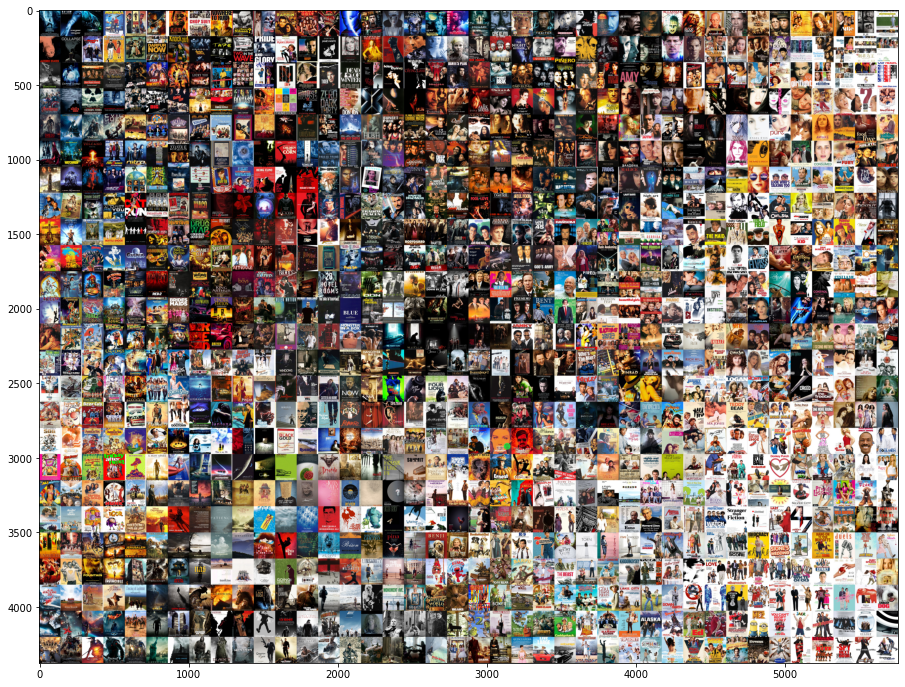

In [27]:
tile_width = 144
tile_height = 175

full_width = tile_width * nx
full_height = tile_height * ny
aspect_ratio = float(tile_width) / tile_height

grid_image = Image.new('RGB', (full_width, full_height))

for img, grid_pos in zip(images, grid_assignment[0]):
    idx_x, idx_y = grid_pos
    x, y = tile_width * idx_x, tile_height * idx_y
    tile = Image.open(img)
    tile_ar = float(tile.width) / tile.height  # center-crop the tile to match aspect_ratio
    if (tile_ar > aspect_ratio):
        margin = 0.5 * (tile.width - aspect_ratio * tile.height)
        tile = tile.crop((margin, 0, margin + aspect_ratio * tile.height, tile.height))
    else:
        margin = 0.5 * (tile.height - float(tile.width) / aspect_ratio)
        tile = tile.crop((0, margin, tile.width, margin + float(tile.width) / aspect_ratio))
    tile = tile.resize((tile_width, tile_height), Image.ANTIALIAS)
    grid_image.paste(tile, (int(x), int(y)))

matplotlib.pyplot.figure(figsize = (16,12))
imshow(grid_image)

In [28]:
grid_image.save("C:/Users/Sabah Afzal/example-tSNE-MoviePosters-grid29.png")

To show the recommendations obtained in the t-SNE we will define two functions. 

One being 'get_closest_images_tsne', which will compute the cosine distance between the t-SNE features of 'query_image_idx'-th image in our dataset, and the t-SNE features of every image in the dataset (including itself, trivially 0). It then returns an array of indices to the 'num_results' (default is 5) most similar images to it (not including itself). 

We also define a second function 'get_concatenated_images_tsne' which will take the resulting images and concatenate them into a single image for easy display.


In [29]:
def get_closest_images_tsne(query_image_idx, num_results=5):
    distances = [ distance.cosine(tsne[query_image_idx], feat) for feat in tsne ]
    idx_closest = sorted(range(len(distances)), key=lambda k: distances[k])[1:num_results+1]
    return idx_closest

def get_concatenated_images_tsne(indexes, thumb_height):
    thumbs = []
    for idx in indexes:
        img = image.load_img(images[idx])
        img = img.resize((int(img.width * thumb_height / img.height), thumb_height))
        thumbs.append(img)
    concat_image = np.concatenate([np.asarray(t) for t in thumbs], axis=1)
    return concat_image

Text(0.5, 1.0, 'result images')

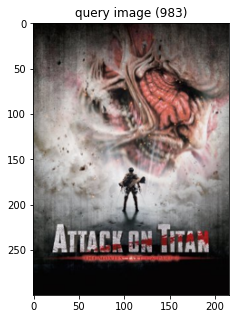

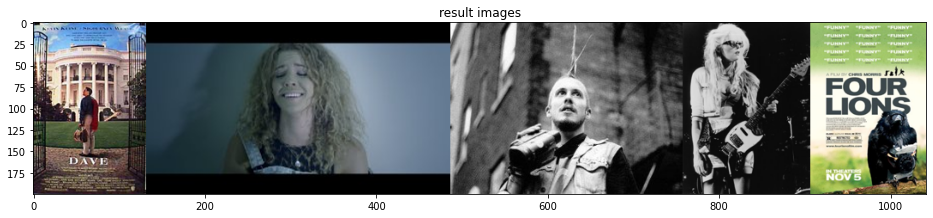

In [30]:
# do a query on a random image
query_image_idx = int(len(images) * random.random())
idx_closest = get_closest_images_tsne(query_image_idx)
query_image = get_concatenated_images_tsne([query_image_idx], 300)
results_image = get_concatenated_images_tsne(idx_closest, 200)

# display the query image
plt.figure(figsize = (5,5))
plt.imshow(query_image)
plt.title("query image (%d)" % query_image_idx)

# display the resulting images
plt.figure(figsize = (16,12))
plt.imshow(results_image)
plt.title("result images")

In [11]:
%load_ext watermark

%watermark -v -m -p keras,numpy,os,cv2,matplotlib,tensorflow,keras,tarfile,time,random,json,PIL,sklearn,watermark

print(" ")
%watermark -u -n -t -z

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Python implementation: CPython
Python version       : 3.8.3
IPython version      : 7.16.1

keras     : 2.4.3
numpy     : 1.19.3
os        : unknown
cv2       : 4.4.0
matplotlib: 3.3.2
tensorflow: 2.4.0
tarfile   : 0.9.0
time      : unknown
random    : unknown
json      : 2.0.9
PIL       : 7.0.0
sklearn   : 0.24.0
watermark : 2.2.0

Compiler    : MSC v.1916 64 bit (AMD64)
OS          : Windows
Release     : 10
Machine     : AMD64
Processor   : Intel64 Family 6 Model 142 Stepping 12, GenuineIntel
CPU cores   : 8
Architecture: 64bit

 
Last updated: Sat May 01 2021 09:34:50Rom, sommertid

